In [1]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import pandas as pd
import os
import random
import shutil
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [6]:
original_dir = Path('/Users/nidhipareddy/Desktop/uchicago/Computer Vision/ai_art_classification/train')
new_base = Path('/Users/nidhipareddy/Desktop/uchicago/Computer Vision/ai_art_classification/split_data')
new_train = new_base / 'train'
new_test = new_base / 'test'

#make the test and train splits and save 
for d in [new_train, new_test]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

split_ratio = 0.2
for class_dir in original_dir.glob("*"):
    if not class_dir.is_dir():
        continue
    images = list(class_dir.glob("*.jpg"))
    random.shuffle(images)
    split_idx = int(len(images) * (1 - split_ratio))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    (new_train / class_dir.name).mkdir(parents=True, exist_ok=True)
    (new_test / class_dir.name).mkdir(parents=True, exist_ok=True)

    for img in train_images:
        shutil.copy(img, new_train / class_dir.name / img.name)
    for img in test_images:
        shutil.copy(img, new_test / class_dir.name / img.name)


In [15]:
train_dir = '/Users/nidhipareddy/Desktop/uchicago/Computer Vision/ai_art_classification/split_data/train'
test_dir  = '/Users/nidhipareddy/Desktop/uchicago/Computer Vision/ai_art_classification/split_data/test'

In [16]:
img_size = (224, 224)
batch_size = 32
seed = 42

#training, test, and val splits
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Found 14894 files belonging to 2 classes.
Using 11916 files for training.
Found 14894 files belonging to 2 classes.
Using 2978 files for validation.
Found 3724 files belonging to 2 classes.


In [17]:
# Create the model
base_model = EfficientNetB1(
    include_top=False,
    weights=None,  # No pretraining
    input_shape=(224, 224, 3)
)
base_model.trainable = True  # Train all layers 

# Define the inputs 
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=True) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compile with a high learning rate 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3423s 9s/step - accuracy: 0.6679 - loss: 0.6351 - val_accuracy: 0.4674 - val_loss: 0.8536 - learning_rate: 0.0010
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 1565s 4s/step - accuracy: 0.7874 - loss: 0.4686 - val_accuracy: 0.8062 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 1196s 3s/step - accuracy: 0.8152 - loss: 0.4236 - val_accuracy: 0.8435 - val_loss: 0.3534 - learning_rate: 0.0010
Epoch 4/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 1188s 3s/step - accuracy: 0.8407 - loss: 0.3608 - val_accuracy: 0.8617 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 5/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 1067s 3s/step - accuracy: 0.8650 - loss: 0.3216 - val_accuracy: 0.8670 - val_loss: 0.3140 - learning_rate: 0.0010
Epoch 6/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 1087s 3s/step - accuracy: 0.8796 - loss: 0.3001 - val_accuracy: 0.8721 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 7/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2703s 7s/step - accuracy: 0.8869 - l

Found 3724 files belonging to 2 classes.


2025-05-23 20:45:21.660100: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


117/117 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step

Accuracy: 89.42%

Classification Report:

                  precision    recall  f1-score   support

    AI_GENERATED       0.88      0.93      0.91      2066
NON_AI_GENERATED       0.91      0.85      0.88      1658

        accuracy                           0.89      3724
       macro avg       0.90      0.89      0.89      3724
    weighted avg       0.89      0.89      0.89      3724

Confusion Matrix:
[[1926  140]
 [ 254 1404]]


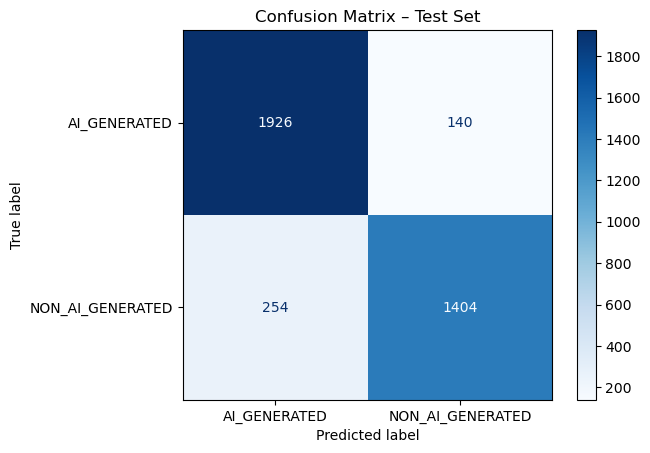

In [21]:
# Load test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # no shuffling
)

# Extract labels and class names
y_true = np.concatenate([y for x, y in test_ds], axis=0)
class_names = test_ds.class_names

# Predict on test data
y_prob = model.predict(test_ds)
y_pred = (y_prob > 0.5).astype("int").flatten()

# Print accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc * 100:.2f}%\n")

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Test Set")
plt.show()

In [20]:
model.save('ai_art_detector.h5')